In [1]:
%matplotlib inline

In [2]:
import numpy as np
import einops as ein
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
from kilroyplot.plot import plt
from tqdm import tqdm

In [3]:
def squash_packed(x, fn):
    return rnn.PackedSequence(fn(x.data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)

def unpad_sequence(x, lengths):
    return [s[:length] for s, length in zip(x, lengths)]

In [4]:
evaluate = lambda x: -1 if len(x) > 3 else x.count(4)

In [5]:
class Actor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        is_packed = isinstance(x, rnn.PackedSequence)
        x = squash_packed(x, self.embedding) if is_packed else self.embedding(x)
        out, _ = self.lstm(x)
        y = squash_packed(out, self.linear) if is_packed else self.linear(out)
        return squash_packed(y, lambda yf: F.softmax(yf, dim=-1)) if is_packed else F.softmax(y, dim=-1)

In [6]:
class Critic(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = squash_packed(x, self.embedding) if isinstance(x, rnn.PackedSequence) else self.embedding(x)
        _, (ht, _) = self.lstm(x)
        return self.linear(ht[-1])

In [7]:
class Generator:
    def __init__(self, model, start_word, end_word, pad_word, max_length):
        self.model = model
        self.start_word = start_word
        self.end_word = end_word
        self.pad_word = pad_word
        self.max_length = max_length
        
    def generate(self, n=1):
        out = []
        x = torch.tensor([[self.start_word]] * n)
        i = 1
        while len(x) > 0 and i < self.max_length:
            batched_probs = self.model(x)[:, -1]
            next_words = self.pick_words(batched_probs)
            x = torch.cat((x, next_words.unsqueeze(-1)), dim=-1)
            finished_mask = next_words == self.end_word
            finished = x[finished_mask]
            out.extend(list(finished))
            x = x[~finished_mask]
            i += 1
        out.extend(list(x))
        out = sorted(out, key=lambda s: len(s), reverse=True)
        lengths = [len(s) for s in out]
        out = rnn.pad_sequence(out, batch_first=True, padding_value=self.pad_word)
        return rnn.pack_padded_sequence(out, lengths, batch_first=True)
    
    def pick_words(self, batched_probs):
        return torch.tensor([Categorical(probs).sample() for probs in batched_probs])

In [8]:
start_word, stop_word, pad_word = 1, 2, 0
vocab_size = 3 + 2
max_length = 5
embedding_dim, hidden_dim, out_dim = 16, 16, vocab_size

In [9]:
actor = Actor(vocab_size, embedding_dim, hidden_dim, out_dim)
critic = Critic(vocab_size, embedding_dim, hidden_dim)

In [10]:
generator = Generator(actor, start_word, stop_word, pad_word, max_length)

In [11]:
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

In [12]:
criterion = nn.MSELoss()

In [13]:
epochs = 1000
actor_iters = 1
actor_batch_size = 64
critic_iters = 1
critic_batch_size = 64

In [14]:
critic_losses = []
actor_losses = []
actor_rewards = []

for i in tqdm(range(epochs)):
    critic_epoch_losses = []
    critic_optimizer.zero_grad()
    for _ in range(critic_iters):
        sentences = generator.generate(critic_batch_size)
        pred_rewards = critic(sentences)
        padded_sentences, lengths = rnn.pad_packed_sequence(sentences, batch_first=True, padding_value=pad_word)
        real_rewards = torch.tensor([evaluate(s.tolist()) for s in unpad_sequence(padded_sentences, lengths)]).unsqueeze(-1).float()
        loss = criterion(pred_rewards, real_rewards)
        loss.backward()
        critic_epoch_losses.append(loss.item())
    critic_optimizer.step()
    critic_losses.append(np.mean(critic_epoch_losses))
    
    actor_epoch_losses = []
    actor_epoch_rewards = []
    actor_optimizer.zero_grad()
    for _ in range(actor_iters):
        sentences = generator.generate(actor_batch_size)
        rewards = critic(sentences)
        preds = actor(sentences)
        sentences_padded, sentences_lengths = rnn.pad_packed_sequence(sentences, batch_first=True)
        preds_padded, preds_lengths = rnn.pad_packed_sequence(preds, batch_first=True)
        probs = [
            torch.gather(p[:-1], -1, s[1:].unsqueeze(-1)).squeeze(-1)
            for s, p in zip(
                unpad_sequence(sentences_padded, sentences_lengths),
                unpad_sequence(preds_padded, preds_lengths)
            )
        ]
        loss = torch.cat([
            -(r * torch.log(p).sum())
            for p, r in zip(probs, rewards)
        ]).mean()
        loss.backward()
        actor_epoch_losses.append(loss.item())
        actor_epoch_rewards.append(rewards.mean().item())
    actor_optimizer.step()
    actor_losses.append(np.mean(actor_epoch_losses))
    actor_rewards.append(np.mean(actor_epoch_rewards))

100%|██████████| 1000/1000 [00:52<00:00, 19.00it/s]


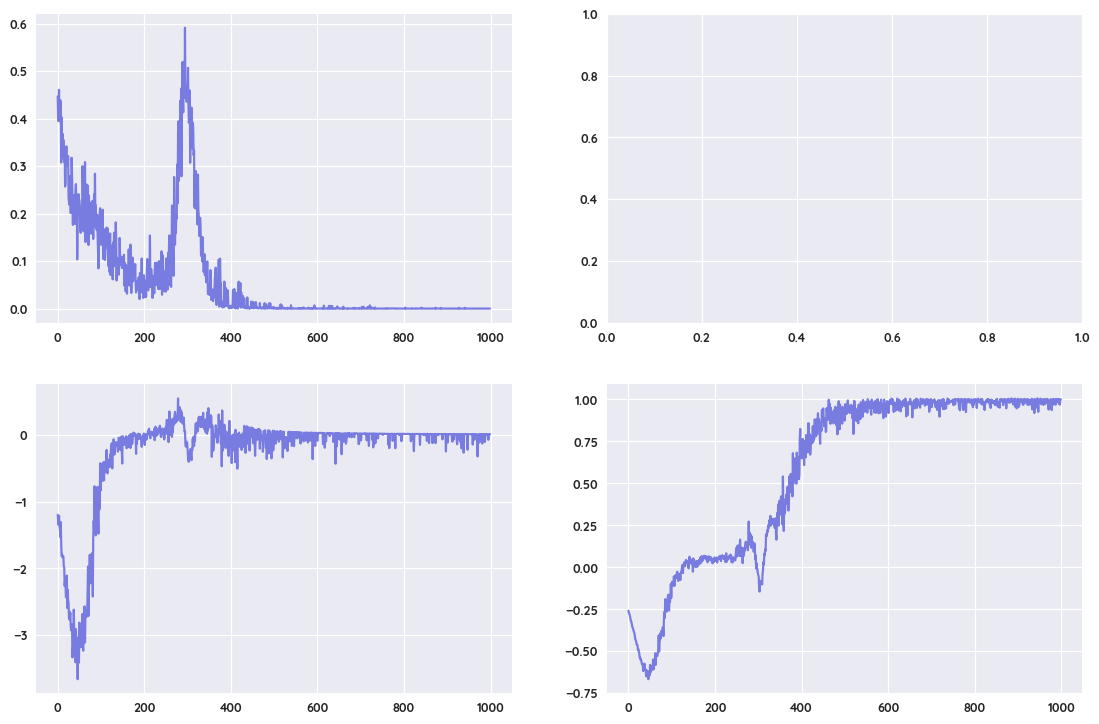

In [15]:
_, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].plot(critic_losses)
axs[1][0].plot(actor_losses)
axs[1][1].plot(actor_rewards)

In [16]:
padded_sentences, lengths = rnn.pad_packed_sequence(generator.generate(20), batch_first=True, padding_value=pad_word)
for sentence in unpad_sequence(padded_sentences, lengths):
    batched_sentence = sentence.unsqueeze(0)
    reward = critic(batched_sentence)[0].item()
    real_score = evaluate(sentence.tolist())
    preds = actor(batched_sentence)
    probs = torch.gather(preds, -1, batched_sentence.unsqueeze(-1)).squeeze(-1)
    loss = -(reward * torch.log(probs).sum()).item()
    print(f"Sentence: {sentence.tolist()}, critic score, {reward:.3f}, real score: {real_score:.3f}, loss: {loss:.3f}")

Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.000, real score: 1.000, loss: 14.918
Sentence: [1, 4, 2], critic score, 1.0